# Advanced DL and RL: Домашнее задание 1

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import gym
from gym.utils import seeding

import caffeine

In [2]:
caffeine.on(display=False)

Первое ДЗ связано с обучением с подкреплением, и оно придумано для ситуации, когда нейронные сети ещё не нужны, и пространство состояний в целом достаточно маленькое, чтобы можно было обучить хорошую стратегию методами TD-обучения или другими методами обучения с подкреплением. Задание получилось, надеюсь, интересное, но в том числе и достаточно техническое, так что для решения придётся немножко попрограммировать. Поэтому ​в качестве решения ожидается ссылка на jupyter-ноутбук на вашем github (или публичный, или с доступом для snikolenko); ссылку обязательно нужно прислать в виде сданного домашнего задания на портале Академии.​Любые комментарии, новые идеи и рассуждения на тему, как всегда, категорически приветствуются.

## Часть первая, с блекджеком и стратегиями

Мы будем обучаться играть в очень простую, но всё-таки знаменитую и популярную игру: блекджек. Правила блекджека достаточно просты; давайте начнём с самой базовой версии, которая реализована в OpenAI Gym:

➢ численные значения карт равны от 2 до 10 для карт от двойки до десятки, 10 для валетов, дам и королей;

➢ туз считается за 11 очков, если общая сумма карт на руке при этом не превосходит 21 (по-английски в этом случае говорят, что на руке есть usable ace), и за 1 очко, если превосходит;

➢ игроку раздаются две карты, дилеру — одна в открытую и одна в закрытую;

➢ игрок может совершать одно из двух действий:

    ○ hit​— взять ещё одну карту;
    ○ stand​— не брать больше карт;
    
➢ если сумма очков у игрока на руках больше 21, он проигрывает (bust);

➢ если игрок выбирает stand с суммой не больше 21, дилер добирает карты, пока
сумма карт в его руке меньше 17;

➢ после этого игрок выигрывает, если дилер либо превышает 21, либо получает

сумму очков меньше, чем сумма очков у игрока; при равенстве очков объявляется
ничья (ставка возвращается);

➢ в исходных правилах есть ещё дополнительный бонус за natural blackjack: если
игрок набирает 21 очко с раздачи, двумя картами, он выигрывает не +1, а +1.5 (полторы ставки).

### 1. Рассмотрим очень простую стратегию: говорить stand, если у нас на руках комбинация в 19, 20 или 21 очко, во всех остальных случаях говорить hit. Используйте методы Монте-Карло, чтобы оценить выигрыш от этой стратегии.*

In [3]:
env = gym.make('Blackjack-v0', natural=True)

In [4]:
def sample_policy(observation):
    score, dealer_score, usable_ace = observation
    return 0 if score >= 19 else 1

In [5]:
n_iters = 100000
avg_V = 0
for i in range(1, n_iters+1):
    observation = env.reset()
    done = False
    while not done:
        action = sample_policy(observation)
        observation, G, done, info = env.step(action)
    avg_V += (G - avg_V) / i

In [6]:
print("Средняя награда при простой стратегии:", avg_V)

Средняя награда при простой стратегии: -0.18794500000000194


### 2. Реализуйте метод обучения с подкреплением без модели (можно Q-обучение, но рекомендую попробовать и другие, например Monte Carlo control) для обучения стратегии в блекджеке, используя окружение Blackjack-v0 из OpenAI Gym.


In [7]:
class Qlearning:
    def __init__(self, alpha=0.00001, gamma=1, eps=0.1, env='Blackjack-v0'):
        self.Q = {}
        self.alpha = alpha
        self.gamma = gamma
        self.eps = eps
        if env == 'Blackjack-v0':
            self.env = gym.make('Blackjack-v0', natural=True)
            self.na = self.env.action_space.n
        elif env == 'DoubleBlackjack':
            self.env = DoubleBlackjackEnv()
            self.na = self.env.na
        
        elif env == 'СountingDoubleBlackjack':
            self.env = СountingDoubleBlackjackEnv()
            self.na = self.env.na
    
    def get_rewards(self, state):
        if state not in self.Q.keys():
            self.Q[state] = np.zeros(self.na)
        return self.Q[state]
    
    def get_next_action(self, state):
        rewards = self.get_rewards(state)
        return np.argmax(rewards)
    
    def epsilon_greedy_policy(self, state):
        if np.random.rand() < self.eps:
            action = np.random.choice([0, 1])
        else:
            action = self.get_next_action(state)
        return action
            
    def run_episode(self):
        state = self.env.reset()
        done = False
        steps = []
        while not done:
            action = self.epsilon_greedy_policy(state)
            steps.append((state, action))
            state, reward, done, _ = self.env.step(action)
        return steps, reward
    
    def train(self, n_iters=200000):
        for n in range(n_iters):
            steps, reward = self.run_episode()
            for state, action in steps[::-1]:
                reward = self.get_rewards(state)[action] + self.alpha * \
                (reward + self.gamma * np.max(self.Q[state]) - self.get_rewards(state)[action])
                self.Q[state][action] = reward
    
    def inference(self, n_iters=100000):
        avg_V = 0
        for i in range(1, n_iters+1):
            state = self.env.reset()
            done = False
            while not done:
                action = self.get_next_action(state)
                state, G, done, _ = self.env.step(action)
            avg_V += (G - avg_V) / i
        return avg_V

In [8]:
%%time
QL = Qlearning()
QL.train()

CPU times: user 12.4 s, sys: 533 ms, total: 12.9 s
Wall time: 12.5 s


### 3. Сколько выигрывает казино у вашей стратегии? Нарисуйте графики среднего дохода вашего метода (усреднённого по крайней мере по 100000 раздач, а лучше больше) по ходу обучения. Попробуйте подобрать оптимальные гиперпараметры.

In [9]:
QL.inference()

-0.08197500000000082

#### Найдем оптимальные гиперпараметры

In [10]:
Alpha=np.linspace(0.00001, 0.001, 10)
Eps = np.linspace(0.05, 0.3, 10)
best_gain = -10
for alpha in Alpha:
    for eps in Eps:
        QL = Qlearning(alpha=alpha, eps=eps)
        QL.train(50000)
        gain = QL.inference()
        if gain > best_gain:
            best_gain = gain
            best_alpha = alpha
            best_eps = eps

print(f"best gain: {best_gain}, best alpha: {best_alpha}, best eps: {best_eps}")

best gain: -0.03447999999999999, best alpha: 0.00023, best eps: 0.21666666666666667


In [11]:
#best_alpha, best_eps = 0.00056, 0.1
QL = Qlearning(alpha=best_alpha, eps=best_eps)
delta_inf = 1000
n_iters = 50000
G = [QL.inference()]
episode = [0]
step = n_iters//delta_inf
for i in range(1, step+1):
    QL.train(delta_inf)
    gain = QL.inference()
    G.append(gain)
    episode.append(i*delta_inf)

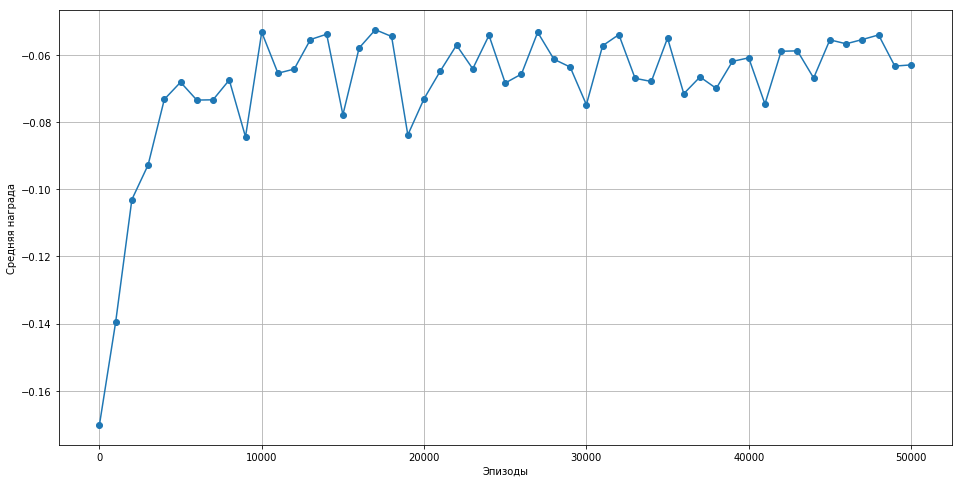

In [15]:
plt.figure(figsize=(16, 8))
plt.plot(episode, G, 'o-')
plt.xlabel('Эпизоды')
plt.ylabel('Средняя награда')
plt.grid()
plt.show()

In [16]:
print("Средняя награда:", gain)

Средняя награда: -0.06299000000000131


## Часть вторая, удвоенная

В базовый блекджек, описанный в предыдущем разделе, обыграть казино вряд ли получится. Но, к счастью, на этом история не заканчивается. Описанные выше правила были упрощёнными, а на самом деле у игрока есть ещё и другие возможности. Реализовывать split может оказаться непросто, поэтому давайте ограничимся удвоением ставки. Итак, у игрока появляется дополнительное действие:

    ➢ double — удвоить ставку; при этом больше действий делать нельзя, игроку выдаётся ровно одна дополнительная карта, а выигрыш или проигрыш удваивается.

### 4. Реализуйте новый вариант блекджека на основе окружения Blackjack-v0 из OpenAI Gym, в котором разрешено удвоение ставки.

In [17]:
class DoubleBlackjackEnv:
    def __init__(self):
        self.base_env = gym.make('Blackjack-v0', natural=True)
        self.na = 3
        
    def reset(self):
        return self.base_env.reset()
    
    def step(self, action):
        if action == 2:
            state, reward, done, info = self.base_env.step(1)
            if done:
                return state, 2*reward, done, info
            else:
                state, reward, done, info = self.base_env.step(0)
                return state, 2*reward, done, info
        else:
            return self.base_env.step(action)

In [18]:
%%time
QL = Qlearning(env="DoubleBlackjack")
QL.train(100000)

CPU times: user 6.14 s, sys: 155 ms, total: 6.29 s
Wall time: 6.19 s


In [19]:
QL.inference()

-0.12082000000000055

### 5. Реализуйте метод обучения с подкреплением без модели для этого варианта, постройте графики, аналогичные п.2.

In [ ]:
Alpha=np.linspace(0.00001, 0.001, 10)
Eps = np.linspace(0.05, 0.3, 10)
best_gain = -10
for alpha in Alpha:
    for eps in Eps:
        QL = Qlearning(alpha=alpha, eps=eps, env="DoubleBlackjack")
        QL.train(50000)
        gain = QL.inference()
        if gain > best_gain:
            best_gain = gain
            best_alpha = alpha
            best_eps = eps

print(f"best gain: {best_gain}, best alpha: {best_alpha}, best eps: {best_eps}")

In [ ]:
#best_alpha, best_eps = 0.00012, 0.1
QL = Qlearning(alpha=best_alpha, eps=best_eps, env="DoubleBlackjack")
delta_inf = 1000
n_iters = 50000
G = [QL.inference()]
episode = [0]
step = n_iters//delta_inf
for i in range(1, step+1):
    QL.train(delta_inf)
    gain = QL.inference()
    G.append(gain)
    episode.append(i*delta_inf)

In [ ]:
plt.figure(figsize=(16, 8))
plt.plot(episode, G, 'o-')
plt.xlabel('Эпизоды')
plt.ylabel('Средняя награда')
plt.grid()
plt.show()

In [ ]:
print("Средняя награда:", gain)

## Часть третья, в главной роли — Дастин Хоффман

А теперь давайте вспомним, как играют в блекджек настоящие профессионалы. Дело в том, что в оффлайн-казино обычно не перемешивают колоду после каждой раздачи — это слишком замедляло бы игру. После раздачи карты просто раздаются дальше с верха колоды до тех пор, пока карт не останется слишком мало, и только тогда колода перемешивается; давайте для определённости считать, что наше казино будет перемешивать колоду, в которой осталось меньше 15 карт.
Действительно, если вы будете запоминать, какие карты уже вышли, у вас будет информация о том, какие карты ещё остались, а это позволяет лучше понять, когда нужно удваивать ставку или делать split, а когда лучше не стоит. В настоящем казино могут раздавать карты сразу из нескольких колод, и заслуга Rain Man’а была в том, что он смог считать карты в шести колодах одновременно. Но мы с вами вооружены компьютерами, так что подсчёт можно считать автоматическим.

### 6. Реализуйте вариант окружения Blackjack-v0 из предыдущей части (с удвоением), в котором игрок имеет возможность “считать карты” в колоде.

In [57]:
class СountingDoubleBlackjackEnv(gym.Env):
    def __init__(self, natural=True):
        self.natural = natural
        self.na = 3
        self.deck = 4 * [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10]
        self.seed()

    def cmp(self, a, b):
        return float(a > b) - float(a < b)


    def draw_card(self, np_random):
        card = self.np_random.choice(self.deck)
        self.deck.remove(card)
        return card


    def draw_hand(self, np_random):
        return [self.draw_card(np_random), self.draw_card(np_random)]


    def usable_ace(self, hand):  # Does this hand have a usable ace?
        return 1 in hand and sum(hand) + 10 <= 21


    def sum_hand(self, hand):  # Return current hand total
        if self.usable_ace(hand):
            return sum(hand) + 10
        return sum(hand)


    def is_bust(self, hand):  # Is this hand a bust?
        return self.sum_hand(hand) > 21


    def score(self, hand):  # What is the score of this hand (0 if bust)
        return 0 if self.is_bust(hand) else self.sum_hand(hand)


    def is_natural(self, hand):  # Is this hand a natural blackjack?
        return sorted(hand) == [1, 10]

    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def step(self, action):
        if action == 2:
            state, reward, done, info = self.step(1)
            if done:
                return state, 2*reward, done, info
            else:
                state, reward, done, info = self.step(0)
                return state, 2*reward, done, info
        elif action:  # hit: add a card to players hand and return
            self.player.append(self.draw_card(self.np_random))
            if self.is_bust(self.player):
                done = True
                reward = -1.
            else:
                done = False
                reward = 0.
        else:  # stick: play out the dealers hand, and score
            done = True
            while self.sum_hand(self.dealer) < 17:
                self.dealer.append(self.draw_card(self.np_random))
            reward = self.cmp(self.score(self.player), self.score(self.dealer))
            if self.natural and self.is_natural(self.player) and reward == 1.:
                reward = 1.5
        return self._get_obs(), reward, done, {}

    def _get_obs(self):
        return (self.sum_hand(self.player), self.dealer[0], self.usable_ace(self.player))

    def reset(self):
        if len(self.deck) < 15:
            self.deck = 4 * [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10]
        self.dealer = self.draw_hand(self.np_random)
        self.player = self.draw_hand(self.np_random)
        return self._get_obs()


In [60]:
QL = Qlearning(env="СountingDoubleBlackjack")
QL.train(100000)

In [61]:
QL.inference()

-0.15362500000000173